### Unidad III. Agrupamiento y clasificación. 

## El análisis discriminante de dos poblaciones como método de comparación Multivariada y técnicas de clasificación. Ideas generales de Fischer.

- El análisis discriminante de dos poblaciones por técnicas de regresión. 
- Generalización del problema de clasificación a más de dos poblaciones.
- Otras técnicas paramétricas.
- Alternativas no paramétricas del análisis discriminante. Modelos Log-lineales.

In [1]:
# Truncate IJulia outputs at:
ENV["LINES"]   = 15 
ENV["COLUMNS"] = 60;

In [2]:
using RCall
using RDatasets

water = dataset("HSAUR", "water")

head(water)

,Location,Town,Mortality,Hardness
1,South,Bath,1247,105
2,North,Birkenhead,1668,17
3,South,Birmingham,1466,5
4,North,Blackburn,1800,14
5,North,Blackpool,1609,18
6,North,Bolton,1558,10


### [Análisis discriminante lineal](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

> As I have described before, Linear Discriminant Analysis (LDA) can be seen from two different angles. The first classify a given sample of predictors $x$ to the class $C_l$ with highest posterior probability $\pi(y = C_l|x)$. **It minimizes the total probability of misclassification.** To compute $\pi(y = C_l|x)$ it uses Bayes’ rule and assume that $\pi(x|y = C_l)$ follows a Gaussian distribution with class-specific mean $\mu_l$ and common covariance matrix $\Sigma$. The second tries to find **a linear combination of the predictors that gives maximum separation between the centers of the data while at the same time minimizing the variation within each group of data.**  
*[...]* pre-processing of the data is important for the application of LDA. **Users should transform, center and scale the data prior to the application of LDA.** It is also useful to remove near-zero variance predictors (almost constant predictors across units). Given that we need to invert the covariance matrix, it is necessary to have less predictors than samples. Attention is therefore needed when using cross-validation.  
>> - [*Thiago G. Martins, Computing and visualizing LDA in R*](https://tgmstat.wordpress.com/2014/01/15/computing-and-visualizing-lda-in-r/)

LDA tiene como supuesto principal que las variables independientes se distribuyen de manera normal. La biblioteca de Julia [**DiscriminantAnalysis**](https://github.com/trthatcher/DiscriminantAnalysis.jl) posee los métodos necesarios para realizar **LDA** y [**QDA** *(Quadratic discriminant analysis)*](https://en.wikipedia.org/wiki/Quadratic_classifier#Quadratic_discriminant_analysis).  

```julia
Pkg.add("DiscriminantAnalysis")
```

In [4]:
using DiscriminantAnalysis

In [5]:
X = convert(Matrix{Float64}, water[:,[:Mortality, :Hardness]])

61x2 Array{Float64,2}:
 1247.0  105.0
 1668.0   17.0
 1466.0    5.0
 1800.0   14.0
 1609.0   18.0
    ⋮         
 1527.0   60.0
 1627.0   53.0
 1486.0  122.0
 1485.0   81.0
 1378.0   71.0

In [6]:
X̄ = mean(X, 1)

1x2 Array{Float64,2}:
 1524.15  47.1803

In [7]:
σₓ = std(X,1)

1x2 Array{Float64,2}:
 187.669  38.094

In [8]:
X = (X .- X̄) ./ σₓ

61x2 Array{Float64,2}:
 -1.47679     1.51782 
  0.766523   -0.79226 
 -0.309841   -1.10727 
  1.46989    -0.871013
  0.45214    -0.766009
  ⋮                   
  0.0151994   0.336528
  0.548053    0.152771
 -0.203271    1.96408 
 -0.208599    0.887796
 -0.778753    0.625287

In [9]:
unique(water[:Location])

2-element DataArrays.DataArray{ByteString,1}:
 "South"
 "North"

In [10]:
y = [ Int(level == "South") + 1 for level in water[:Location] ] # Necesita niveles: 1 2 3 ...

61-element Array{Int64,1}:
 2
 1
 2
 1
 1
 ⋮
 2
 2
 2
 2
 1

In [11]:
LDA = lda(X,y)

Linear Discriminant Model

Regularization Parameters:
    γ = N/A

Class Priors:
    Class 1 Probability: 50.0%
    Class 2 Probability: 50.0%

Class Means:
    Class 1 Mean: [0.583222, -0.440498]
    Class 2 Mean: [-0.785106, 0.592978]




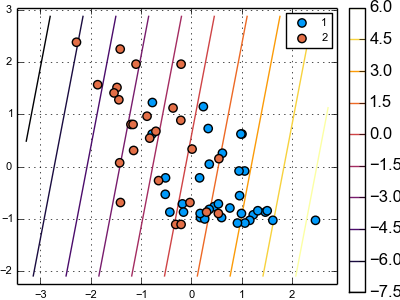

In [14]:
using Plots
pyplot(size=(400,300))

xmin, xmax = extrema(X[:,1])
ymin, ymax = extrema(X[:,2])

function value(modelo, x, y)
    a, b = discriminants(modelo,[x y])
    a - b
end

Plots.scatter(X[:,1], X[:,2], group=y)
Plots.contour!(xmin-1:xmax+1, ymin-1:ymax+1, (x, y)->value(LDA,x,y))  

In [15]:
classify(LDA, [ -1.  1.
                 1. -1. ] )

2-element Array{Int64,1}:
 2
 1

#### Más de dos niveles

In [16]:
iris = dataset("datasets","iris")
head(iris)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [17]:
X = convert(Matrix{Float64}, iris[:,3:4])

150x2 Array{Float64,2}:
 1.4  0.2
 1.4  0.2
 1.3  0.2
 1.5  0.2
 1.4  0.2
 ⋮       
 5.2  2.3
 5.0  1.9
 5.2  2.0
 5.4  2.3
 5.1  1.8

In [18]:
X = (X .- mean(X,1)) ./ std(X,1)

150x2 Array{Float64,2}:
 -1.33575   -1.31105 
 -1.33575   -1.31105 
 -1.3924    -1.31105 
 -1.2791    -1.31105 
 -1.33575   -1.31105 
  ⋮                  
  0.816859   1.44399 
  0.703564   0.919223
  0.816859   1.05042 
  0.930154   1.44399 
  0.760211   0.788031

In [19]:
unique(iris[:Species])

3-element DataArrays.DataArray{ByteString,1}:
 "setosa"    
 "versicolor"
 "virginica" 

In [20]:
y = [ sp == "setosa" ? 1 : sp == "versicolor" ? 2 : 3 for sp in iris[:Species] ] 

150-element Array{Int64,1}:
 1
 1
 1
 1
 1
 ⋮
 3
 3
 3
 3
 3

In [21]:
LDA = lda(X,y)

Linear Discriminant Model

Regularization Parameters:
    γ = N/A

Class Priors:
    Class 1 Probability: 33.3333%
    Class 2 Probability: 33.3333%
    Class 3 Probability: 33.3333%

Class Means:
    Class 1 Mean: [-1.30063, -1.2507]
    Class 2 Mean: [0.284371, 0.166177]
    Class 3 Mean: [1.01626, 1.08453]




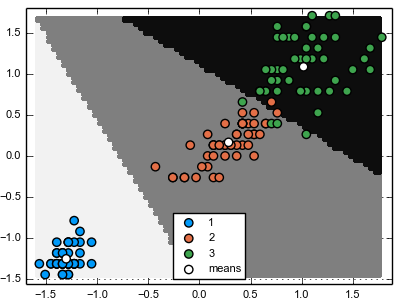

In [22]:
xmin, xmax = extrema(X[:,1])
ymin, ymax = extrema(X[:,2])

Plots.scatter(X[:,1], X[:,2], group=y)
Plots.heatmap!(xmin:0.05:xmax, ymin:0.05:ymax, (x, y) -> classify(LDA,[x y])[1], cbar=false, seriescolor=:grays) 
Plots.scatter!(LDA.M[:,1], LDA.M[:,2], label="means", markercolor=:white, legend=:bottom)

### [MultivariateStats.jl](http://multivariatestatsjl.readthedocs.io/en/latest/index.html)

In [23]:
using MultivariateStats

In [24]:
X = convert(Matrix{Float64}, iris[:,1:4])
X = (X .- mean(X,1)) ./ std(X,1)

150x4 Array{Float64,2}:
 -0.897674    1.0156     -1.33575   -1.31105 
 -1.1392     -0.131539   -1.33575   -1.31105 
 -1.38073     0.327318   -1.3924    -1.31105 
 -1.50149     0.0978893  -1.2791    -1.31105 
 -1.01844     1.24503    -1.33575   -1.31105 
  ⋮                                          
  1.03454    -0.131539    0.816859   1.44399 
  0.551486   -1.27868     0.703564   0.919223
  0.793012   -0.131539    0.816859   1.05042 
  0.430722    0.786174    0.930154   1.44399 
  0.0684325  -0.131539    0.760211   0.788031

In [25]:
X = X'

4x150 Array{Float64,2}:
 -0.897674  -1.1392    -1.38073   …  0.430722   0.0684325
  1.0156    -0.131539   0.327318     0.786174  -0.131539 
 -1.33575   -1.33575   -1.3924       0.930154   0.760211 
 -1.31105   -1.31105   -1.31105      1.44399    0.788031 

In [26]:
LDA = fit(MulticlassLDA, 3, X, y)
projection(LDA)

4x2 Array{Float64,2}:
 -0.0566417   0.00164458
 -0.0551643   0.0778146 
  0.320487   -0.135681  
  0.17669     0.178491  

In [27]:
XY = transform(LDA, X)'

150x2 Array{Float64,2}:
 -0.66492    0.0247782
 -0.587959  -0.0648833
 -0.617745  -0.0218888
 -0.561939  -0.0553123
 -0.670736   0.0424325
  ⋮                   
  0.465591   0.138373 
  0.427201  -0.0299806
  0.40973    0.0677256
  0.485477   0.193419 
  0.386255   0.0273866


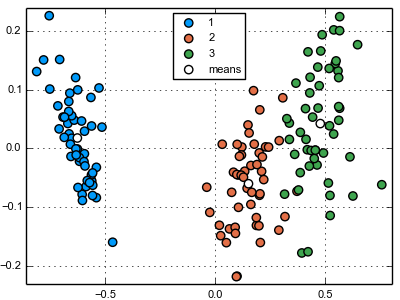

In [28]:
Plots.scatter(XY[:,1], XY[:,2], group=y)
Plots.scatter!(LDA.pmeans[1,:]', LDA.pmeans[2,:]', label="means", markercolor=:white, legend=:top)

> In the pratice of **classification**, one can transform testing samples using this transform method, and compare them with `M.pmeans`.

> When these distributions are assumed to be normal, it turns out that the model is very **similar to logistic regression.** Why do we need this method?  
 - When the classes are well-separated, the parameter estimates for the logistic model are surprisingly unstable. LDA does not suffer from this.  
 - If n is small and the distribution of the predictors X is approximately normal in each of the classes, the LDA model is more stable than logistic.  
 - *[...]* LDA is the preferred method when dealing with > 2 response classes.  
>> [Ryan Kelly, Classification: Linear Discriminant Analysis](https://rpubs.com/ryankelly/LDA-QDA)

### [Modelos Log-Lineales](https://en.wikipedia.org/wiki/Log-linear_model): [Regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_regression)

> Poisson regression is a form of regression analysis used to model count data and contingency tables. Poisson regression assumes the response variable Y has a Poisson distribution, and assumes the logarithm of its expected value can be modeled by a linear combination of unknown parameters. A Poisson regression model is sometimes known as a log-linear model, especially when used to model contingency tables.  
Poisson regression models are generalized linear models with the logarithm as the (canonical) link function, and the Poisson distribution function as the assumed probability distribution of the response.

In [29]:
;head crab.txt

  1        2        3     28.3     3.05        8
  2        3        3     26.0     2.60        4
  3        3        3     25.6     2.15        0
  4        4        2     21.0     1.85        0
  5        2        3     29.0     3.00        1
  6        1        2     25.0     2.30        3
  7        4        3     26.2     1.30        0
  8        2        3     24.9     2.10        0
  9        2        1     25.7     2.00        8
 10        2        3     27.5     3.15        6


> This problem refers to data from a study of nesting [horseshoe crabs](https://en.wikipedia.org/wiki/Horseshoe_crab) (J. Brockmann, Ethology 1996); see also Agresti (1996) Sec. 4.3 and Agresti (2002) Sec. 4.3.  
Each female horseshoe crab in the study had a male crab attached to her in her nest. The study investigated factors that affect whether the female crab had any other males, called satellites, residing near her. Explanatory variables that are thought to affect this included the female crab’s color (C), spine condition (S), weight (Wt), and carapace width (W). The response outcome for each female crab is her number of satellites (Sa). There are 173 females in this study.
>> - *https://onlinecourses.science.psu.edu/stat504/node/169*

In [30]:
using DataFrames
crab = readtable("crab.txt", separator=' ', header=false)
head(crab,3)

,x1,x2,x3,x4,x5,x6
1,1,2,3,28.3,3.05,8
2,2,3,3,26.0,2.6,4
3,3,3,3,25.6,2.15,0


In [31]:
names!(crab,[:Obs,:C,:S,:W,:Wt,:Sa])
head(crab)

,Obs,C,S,W,Wt,Sa
1,1,2,3,28.3,3.05,8
2,2,3,3,26.0,2.6,4
3,3,3,3,25.6,2.15,0
4,4,4,2,21.0,1.85,0
5,5,2,3,29.0,3.0,1
6,6,1,2,25.0,2.3,3


In [32]:
using GLM

In [33]:
modelo = glm(Sa ~ W, crab, Poisson(), LogLink()) # Number of satellites ~ Carapace width

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Sa ~ 1 + W

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -3.30476  0.542219 -6.09488    <1e-8
W            0.164045 0.0199646  8.21678   <1e-15


In [34]:
α, β = (coef(modelo)...)

(-3.3047571452447526,0.16404508398650938)

In [35]:
log_μ(Wᵢ) = α + β*Wᵢ # ̄μ

log_μ (generic function with 1 method)

In [36]:
exp(β)

1.1782674348884261

In [37]:
μ(Wᵢ) = exp(α) * exp(β*Wᵢ)

μ (generic function with 1 method)

In [38]:
xmin, xmax = extrema(crab[:W])

(21.0,33.5)


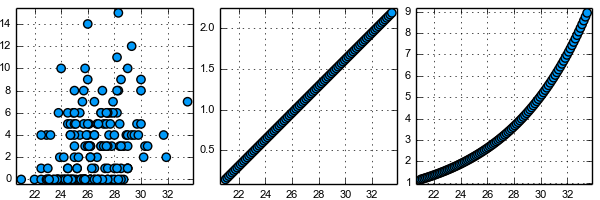

In [39]:
plot(
scatter(crab[:W], crab[:Sa]),
scatter(x -> log_μ(x), xmin, xmax),
scatter(x -> μ(x), xmin, xmax),
xlim=(xmin,xmax), layout=grid(1,3), size=(600,200), legend=false)

#### Tablas de contingencia

In [40]:
using RDatasets

titanic = dataset("COUNT","titanic")
head(titanic)

,Survived,Age,Sex,Class
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
5,1,1,1,1
6,1,1,1,1


In [41]:
datos = by(titanic, [:Sex, :Class], df -> sum(df[:Survived]))

,Sex,Class,x1
1,0,1,141
2,0,2,93
3,0,3,90
4,1,1,62
5,1,2,25
6,1,3,88


In [42]:
glm(x1 ~  Sex + Class, datos, Poisson(), LogLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Poisson,GLM.LogLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: x1 ~ 1 + Sex + Class

Coefficients:
               Estimate Std.Error  z value Pr(>|z|)
(Intercept)     4.83069  0.120615  40.0506   <1e-99
Sex           -0.615958 0.0938114 -6.56591   <1e-10
Class        -0.0752212 0.0549045 -1.37004   0.1707
